In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.95

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "exoverstation," + \
        "sum_wco_ex_q75_period1_2020,"+\
        "sum_wnh3_ex_q75_period1_2020,"+\
        "sum_wnmvoc_ex_q75_period1_2020,"+\
        "sum_wno2_ex_q75_period1_2020,"+\
        "sum_wno_ex_q75_period1_2020,"+\
        "sum_wo3_ex_q75_period1_2020,"+\
        "sum_wpans_ex_q75_period1_2020,"+\
        "sum_wpm10_ex_q75_period1_2020,"+\
        "sum_wpm2p5_ex_q75_period1_2020,"+\
        "sum_wso2_ex_q75_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   matera
   2   milano
   3   la_spezia
   4   cremona
   5   lecce
   6   catanzaro
   7   campobasso
   8   brescia
   9   cosenza
   10   belluno
   11   prato
   12   ferrara
   13   biella
   14   pistoia
   15   rieti
   16   arezzo
   17   grosseto
   18   ragusa
   19   siracusa
   20   bari
   21   livorno
   22   taranto
   23   palermo
   24   treviso
   25   l_aquila
   26   siena
   27   alessandria
   28   firenze
   29   bergamo
   30   macerata
   31   caserta
   32   latina
   33   agrigento
   34   forli
   35   carbonia
   36   caltanissetta
   37   vercelli
   38   trento
   39   massa
   40   enna
   41   pisa
   42   rimini
   43   torino
   44   cagliari
   45   potenza
   46   udine
   47   asti
   48   roma
   49   perugia
   50   varese
   51   bat
   52   ascoli_piceno
   53   napoli
   54   modena
   55   isernia
   56   fermo
   57   pescara
   58   savona
   59   trapani
   60  

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
            ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 matera
2 milano
3 la_spezia
4 cremona
5 lecce
6 catanzaro
7 campobasso
8 brescia
9 cosenza
10 belluno
11 prato
12 ferrara
13 biella
14 pistoia
15 rieti
16 arezzo
17 grosseto
18 ragusa
19 siracusa
20 bari
21 livorno
22 taranto
23 palermo
24 treviso
25 l_aquila
26 siena
27 alessandria
28 firenze
29 bergamo
30 macerata
31 caserta
32 latina
33 agrigento
34 forli
35 caltanissetta
36 vercelli
37 trento
38 massa
39 enna
40 pisa
41 rimini
42 torino
43 cagliari
44 potenza
45 udine
46 asti
47 roma
48 perugia
49 varese
50 bat
51 ascoli_piceno
52 napoli
53 modena
54 fermo
55 pescara
56 savona
57 trapani
58 lecco
59 lucca
60 padova
61 avellino
62 rovigo
63 sondrio
64 foggia
65 trieste
66 chieti
67 verona
68 lodi
69 ravenna
70 nuoro
71 vibo_valentia
72 cuneo
73 pesaro
74 bolzano
75 como
76 sassari
77 bologna
78 viterbo
79 catania
80 monza
81 terni
82 teramo
83 brindisi
84 pavia
85 vicenza
86 piacenza
87 venezia
88 imperia
89 ancona
90 parma
91 messina
92 verbania
93 mantova
94 benevento
95 oristan

In [4]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    #if len(highcorrelated[v1]) > 0:
    #    print(v1)
    #    for fntr in highcorrelated[v1]:
    #        print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

Training set average RMSE:  0.35880  0.02256 
    Test set average RMSE:  0.96826  0.09826 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.35665
                       R2:  0.94179


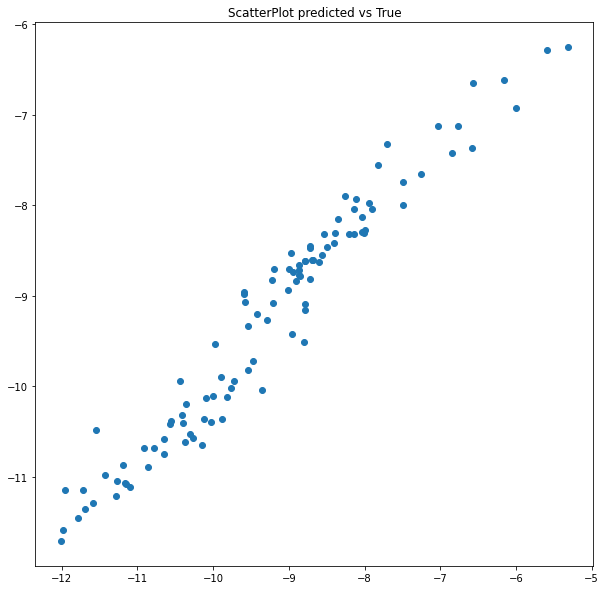

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.04497
Feature:               commutersdensity, Score: 0.04895
Feature:                         depriv, Score: 0.05389
Feature:                            lat, Score: 0.68698
Feature:                 Ratio0200ver65, Score: 0.08043
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.00614
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.00497
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.01236
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02479
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02031
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.00881
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.00741


<Figure size 432x288 with 0 Axes>

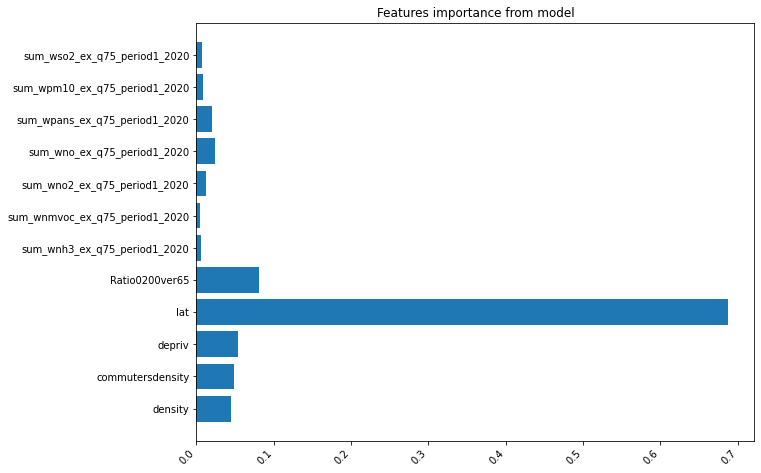

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.11881 +/- 0.01224
Feature:               commutersdensity, Score: 0.06117 +/- 0.00740
Feature:                         depriv, Score: 0.15702 +/- 0.01771
Feature:                            lat, Score: 3.10309 +/- 0.36358
Feature:                 Ratio0200ver65, Score: 0.19236 +/- 0.02856
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.01398 +/- 0.00374
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.02235 +/- 0.00442
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.03213 +/- 0.00573
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.06515 +/- 0.01239
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.04948 +/- 0.01194
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.02019 +/- 0.00353
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.02062 +/- 0.00333


<Figure size 432x288 with 0 Axes>

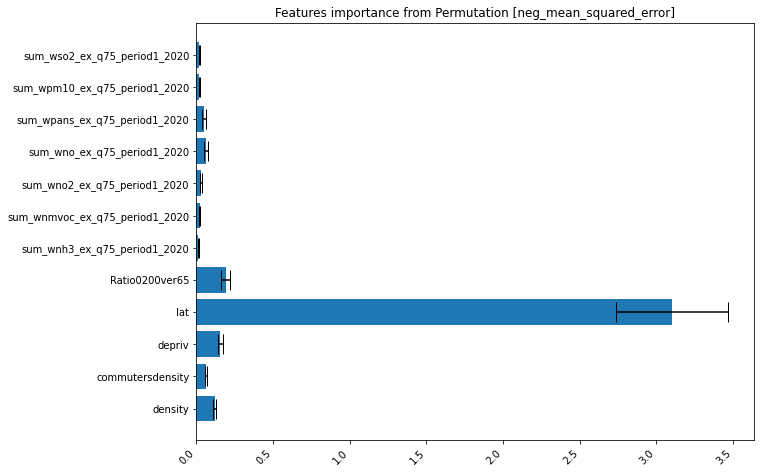

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.05437 +/- 0.00560
Feature:               commutersdensity, Score: 0.02799 +/- 0.00339
Feature:                         depriv, Score: 0.07186 +/- 0.00810
Feature:                            lat, Score: 1.42002 +/- 0.16638
Feature:                 Ratio0200ver65, Score: 0.08803 +/- 0.01307
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.00640 +/- 0.00171
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.01023 +/- 0.00202
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.01470 +/- 0.00262
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02981 +/- 0.00567
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02264 +/- 0.00546
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.00924 +/- 0.00161
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.00944 +/- 0.00153


<Figure size 432x288 with 0 Axes>

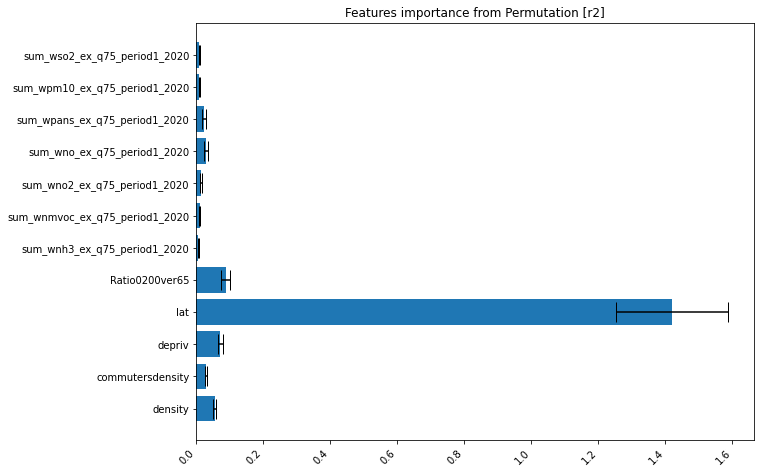

<Figure size 720x720 with 0 Axes>

((0.35879651009879404, 0.022563281028305706),
 (0.9682615775686111, 0.09825573622931343),
 0.3566475033832098,
 {'density': 0.03080910251549163,
  'commutersdensity': 0.01586095686531839,
  'depriv': 0.04071834766589244,
  'lat': 0.8046732455426955,
  'Ratio0200ver65': 0.049881413933399114,
  'sum_wnh3_ex_q75_period1_2020': 0.0036250884689833307,
  'sum_wnmvoc_ex_q75_period1_2020': 0.005795914705232265,
  'sum_wno2_ex_q75_period1_2020': 0.008330612102298034,
  'sum_wno_ex_q75_period1_2020': 0.016893051991022735,
  'sum_wpans_ex_q75_period1_2020': 0.01283102224130747,
  'sum_wpm10_ex_q75_period1_2020': 0.005234740104313138,
  'sum_wso2_ex_q75_period1_2020': 0.005346503864046054},
 {'density': 0.030809102515491647,
  'commutersdensity': 0.015860956865318413,
  'depriv': 0.040718347665892454,
  'lat': 0.8046732455426953,
  'Ratio0200ver65': 0.04988141393339913,
  'sum_wnh3_ex_q75_period1_2020': 0.003625088468983357,
  'sum_wnmvoc_ex_q75_period1_2020': 0.005795914705232292,
  'sum_wno2_ex_

<Figure size 432x288 with 0 Axes>

In [5]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_allfeatures_using_sum", pout=sys.stdout, showplot=True)

In [6]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.1271974416694766
2  of  1200 MSE:  0.13125091455609345
3  of  1200 MSE:  0.201907272521274
4  of  1200 MSE:  0.29297651814824466
5  of  1200 MSE:  0.4504389644629576
6  of  1200 MSE:  0.5680977144469482
7  of  1200 MSE:  0.6239294228209185
8  of  1200 MSE:  0.7192639549170372
9  of  1200 MSE:  0.18824551031716502
10  of  1200 MSE:  0.247793086444525
11  of  1200 MSE:  0.23101006292741266
12  of  1200 MSE:  0.3076462905998202
13  of  1200 MSE:  0.4504389644629576
14  of  1200 MSE:  0.5680977144469482
15  of  1200 MSE:  0.6239294228209185
16  of  1200 MSE:  0.7192639549170372
17  of  1200 MSE:  0.34230265629822765
18  of  1200 MSE:  0.4428521546754841
19  of  1200 MSE:  0.367751991537905
20  of  1200 MSE:  0.470797393528101
21  of  1200 MSE:  0.4504389644629576
22  of  1200 MSE:  0.5680977144469482
23  of  1200 MSE:  0.6239294228209185
24  of  1200 MSE:  0.7192639549170372
25  of  1200 MSE:  0.4532329851087592
26  of  1200 MSE:  0.5467063503418262
27  of  1200 MSE:  0

{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200,
 'random_state': 1}
Training set average RMSE:  0.34970  0.02233 
    Test set average RMSE:  0.94442  0.10236 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.33790
                       R2:  0.94775


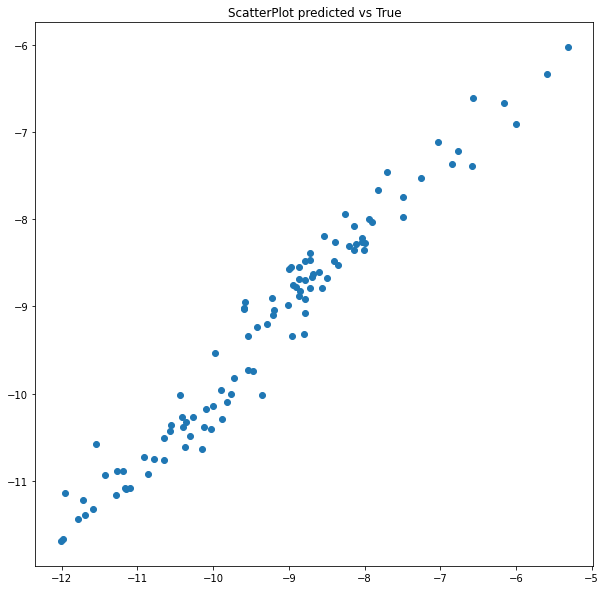

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.06053
Feature:               commutersdensity, Score: 0.17038
Feature:                         depriv, Score: 0.10454
Feature:                            lat, Score: 0.26109
Feature:                 Ratio0200ver65, Score: 0.07697
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.06635
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.06285
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.09589
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.01699
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02232
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.04209
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.02000


<Figure size 432x288 with 0 Axes>

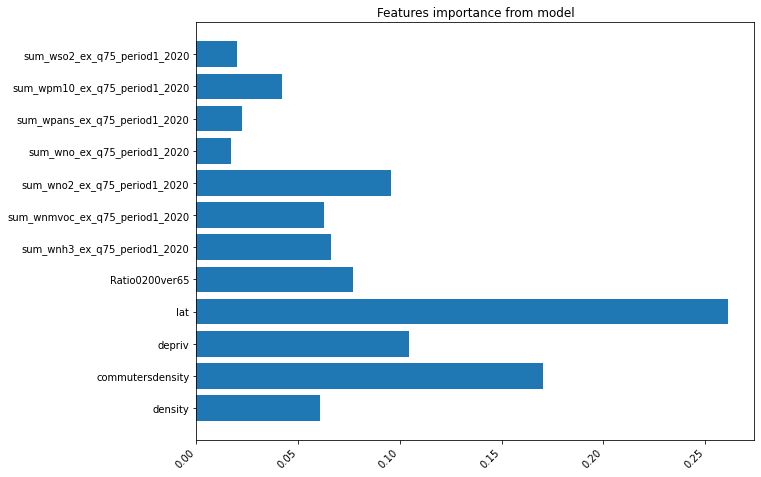

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.12971 +/- 0.01471
Feature:               commutersdensity, Score: 0.05965 +/- 0.00536
Feature:                         depriv, Score: 0.14187 +/- 0.01513
Feature:                            lat, Score: 3.14265 +/- 0.36718
Feature:                 Ratio0200ver65, Score: 0.24137 +/- 0.03642
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.02036 +/- 0.00375
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.01300 +/- 0.00231
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.01242 +/- 0.00207
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.08393 +/- 0.01578
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.05272 +/- 0.01278
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01938 +/- 0.00309
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01208 +/- 0.00217


<Figure size 432x288 with 0 Axes>

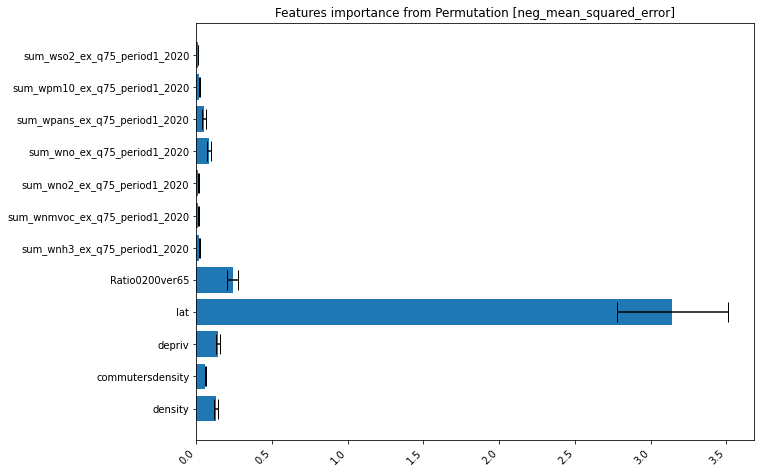

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.05936 +/- 0.00673
Feature:               commutersdensity, Score: 0.02730 +/- 0.00245
Feature:                         depriv, Score: 0.06492 +/- 0.00693
Feature:                            lat, Score: 1.43812 +/- 0.16803
Feature:                 Ratio0200ver65, Score: 0.11045 +/- 0.01667
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.00932 +/- 0.00172
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.00595 +/- 0.00106
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.00568 +/- 0.00095
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.03841 +/- 0.00722
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02412 +/- 0.00585
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.00887 +/- 0.00141
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.00553 +/- 0.00099


<Figure size 432x288 with 0 Axes>

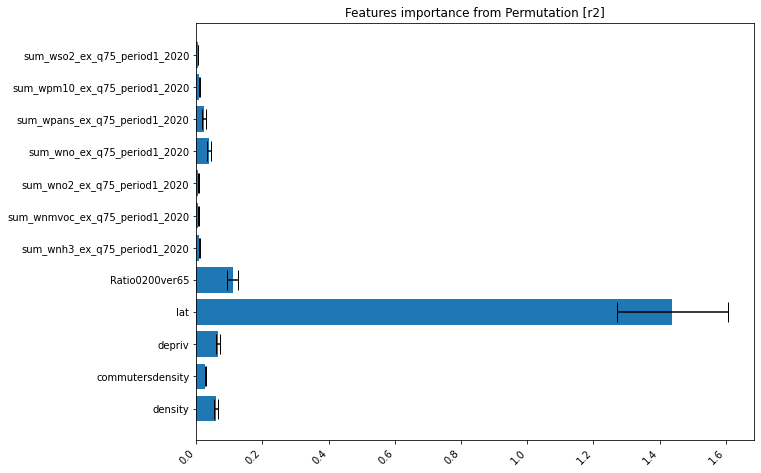

<Figure size 720x720 with 0 Axes>

((0.3497019784125199, 0.02232846988850548),
 (0.9444200369324273, 0.10235567454690465),
 0.3378980276106152,
 {'density': 0.03301174493703693,
  'commutersdensity': 0.015182635467392132,
  'depriv': 0.036107179182648406,
  'lat': 0.7998319643482893,
  'Ratio0200ver65': 0.06142992131610905,
  'sum_wnh3_ex_q75_period1_2020': 0.005182140875890064,
  'sum_wnmvoc_ex_q75_period1_2020': 0.003308907999384614,
  'sum_wno2_ex_q75_period1_2020': 0.0031604469500126024,
  'sum_wno_ex_q75_period1_2020': 0.021360855158837535,
  'sum_wpans_ex_q75_period1_2020': 0.013416767564755612,
  'sum_wpm10_ex_q75_period1_2020': 0.004932350768944908,
  'sum_wso2_ex_q75_period1_2020': 0.003075085430698872},
 {'density': 0.033011744937036944,
  'commutersdensity': 0.015182635467392151,
  'depriv': 0.03610717918264842,
  'lat': 0.799831964348289,
  'Ratio0200ver65': 0.061429921316109054,
  'sum_wnh3_ex_q75_period1_2020': 0.005182140875890089,
  'sum_wnmvoc_ex_q75_period1_2020': 0.0033089079993846374,
  'sum_wno2_ex_

<Figure size 432x288 with 0 Axes>

In [7]:
pprint(bestf)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures_opt_using_sum",showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.39078  0.03234 
    Test set average RMSE:  1.04015  0.12363 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.38809
                       R2:  0.93108


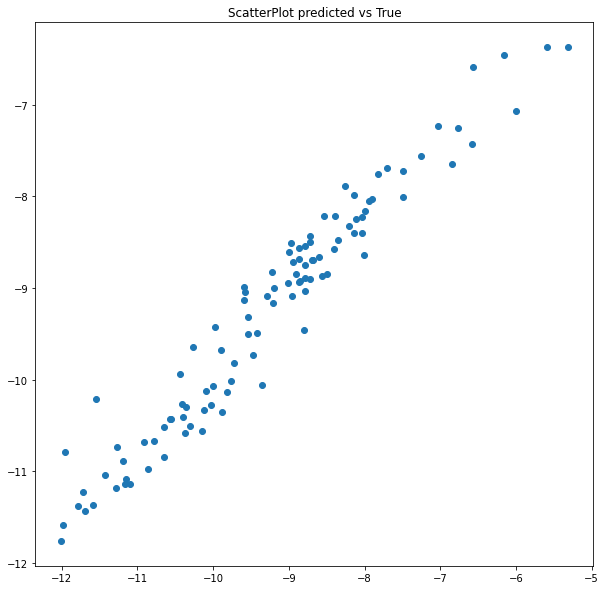

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.07186
Feature:               commutersdensity, Score: 0.52354
Feature:                         depriv, Score: 0.08266
Feature:                 Ratio0200ver65, Score: 0.14534
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.03259
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.02518
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.04048
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02251
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02395
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01665
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01525


<Figure size 432x288 with 0 Axes>

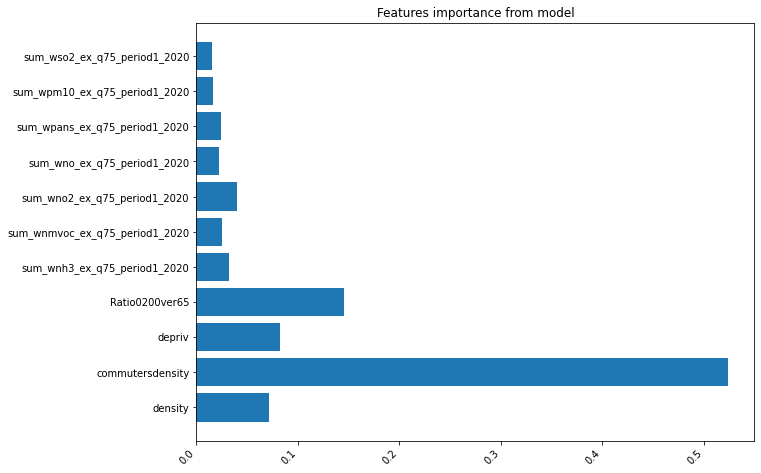

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.16339 +/- 0.01715
Feature:               commutersdensity, Score: 1.74944 +/- 0.26695
Feature:                         depriv, Score: 0.27231 +/- 0.02803
Feature:                 Ratio0200ver65, Score: 0.33392 +/- 0.03728
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.04823 +/- 0.00812
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.03456 +/- 0.00730
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.12595 +/- 0.01851
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.05649 +/- 0.01125
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.03919 +/- 0.00667
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.03856 +/- 0.00674
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.02707 +/- 0.00615


<Figure size 432x288 with 0 Axes>

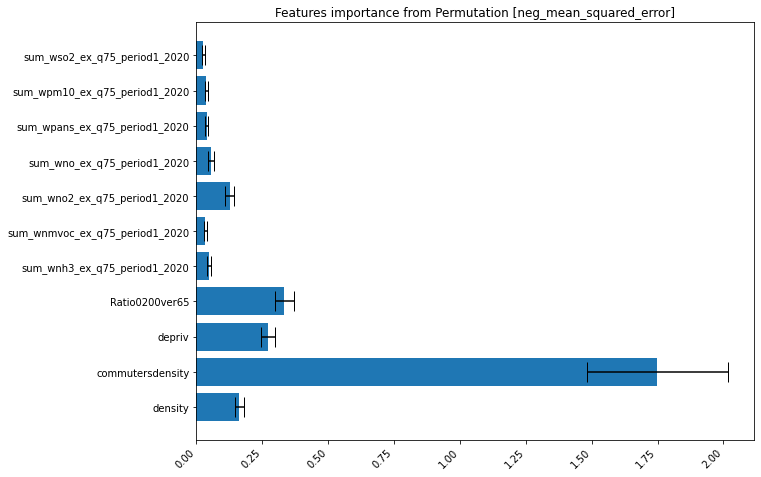

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.07477 +/- 0.00785
Feature:               commutersdensity, Score: 0.80057 +/- 0.12216
Feature:                         depriv, Score: 0.12461 +/- 0.01282
Feature:                 Ratio0200ver65, Score: 0.15281 +/- 0.01706
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.02207 +/- 0.00372
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.01581 +/- 0.00334
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.05764 +/- 0.00847
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02585 +/- 0.00515
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.01793 +/- 0.00305
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01764 +/- 0.00308
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01239 +/- 0.00281


<Figure size 432x288 with 0 Axes>

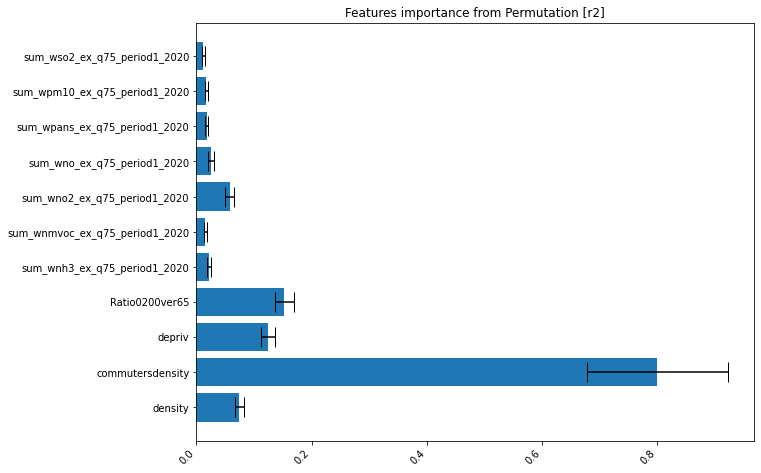

<Figure size 720x720 with 0 Axes>

((0.390777175835448, 0.03233574063348449),
 (1.0401533553083748, 0.1236349263987066),
 0.3880882006342747,
 {'density': 0.05655373600210544,
  'commutersdensity': 0.6055317417991798,
  'depriv': 0.09425427664715726,
  'Ratio0200ver65': 0.11557937308746259,
  'sum_wnh3_ex_q75_period1_2020': 0.01669239557310597,
  'sum_wnmvoc_ex_q75_period1_2020': 0.011961371772402946,
  'sum_wno2_ex_q75_period1_2020': 0.043594026035859004,
  'sum_wno_ex_q75_period1_2020': 0.019553700553934395,
  'sum_wpans_ex_q75_period1_2020': 0.013564295987146521,
  'sum_wpm10_ex_q75_period1_2020': 0.013345666775247775,
  'sum_wso2_ex_q75_period1_2020': 0.009369415766398196},
 {'density': 0.05655373600210544,
  'commutersdensity': 0.60553174179918,
  'depriv': 0.09425427664715723,
  'Ratio0200ver65': 0.11557937308746254,
  'sum_wnh3_ex_q75_period1_2020': 0.016692395573105957,
  'sum_wnmvoc_ex_q75_period1_2020': 0.011961371772402923,
  'sum_wno2_ex_q75_period1_2020': 0.04359402603585899,
  'sum_wno_ex_q75_period1_2020'

<Figure size 432x288 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_using_sum", pout=sys.stdout, showplot=True)

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.15061245147154903
2  of  1200 MSE:  0.1445546025240168
3  of  1200 MSE:  0.2542971582676854
4  of  1200 MSE:  0.3460515641398651
5  of  1200 MSE:  0.5577516961162201
6  of  1200 MSE:  0.6700412656133341
7  of  1200 MSE:  0.7795471082129274
8  of  1200 MSE:  0.8276183479292923
9  of  1200 MSE:  0.23165281054902004
10  of  1200 MSE:  0.31138463148674095
11  of  1200 MSE:  0.28496257297892247
12  of  1200 MSE:  0.39093903873255853
13  of  1200 MSE:  0.5577516961162201
14  of  1200 MSE:  0.6700412656133341
15  of  1200 MSE:  0.7795471082129274
16  of  1200 MSE:  0.8276183479292923
17  of  1200 MSE:  0.40614070319490875
18  of  1200 MSE:  0.5068241020318573
19  of  1200 MSE:  0.44154249118471084
20  of  1200 MSE:  0.553899636615035
21  of  1200 MSE:  0.5577516961162201
22  of  1200 MSE:  0.6700412656133341
23  of  1200 MSE:  0.7795471082129274
24  of  1200 MSE:  0.8276183479292923
25  of  1200 MSE:  0.5339915906616948
26  of  1200 MSE:  0.6347223519339182
27  of  1200 MS

Training set average RMSE:  0.37450  0.02805 
    Test set average RMSE:  1.00130  0.11236 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.35583
                       R2:  0.94206


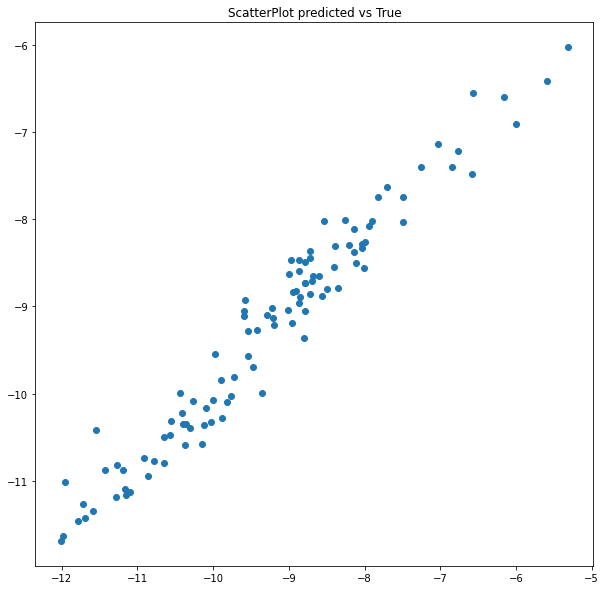

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.07763
Feature:               commutersdensity, Score: 0.24601
Feature:                         depriv, Score: 0.13464
Feature:                 Ratio0200ver65, Score: 0.10305
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.09293
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.09273
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.11341
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.01672
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02919
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.06358
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.03010


<Figure size 432x288 with 0 Axes>

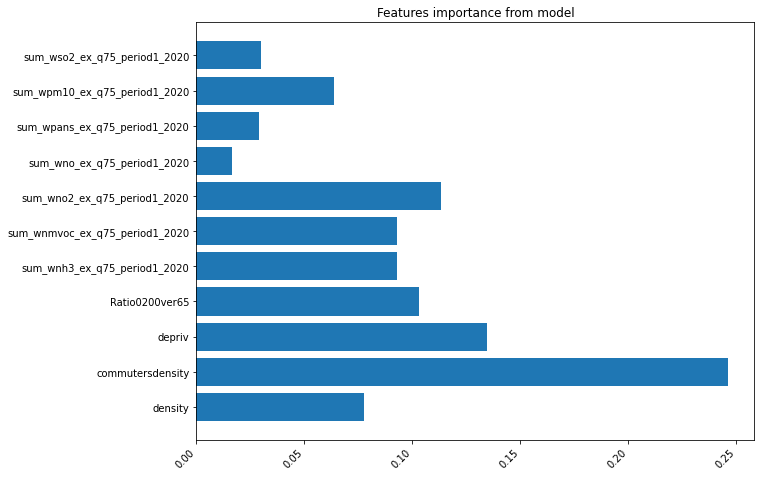

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.17229 +/- 0.01839
Feature:               commutersdensity, Score: 1.83014 +/- 0.26942
Feature:                         depriv, Score: 0.23460 +/- 0.02848
Feature:                 Ratio0200ver65, Score: 0.36423 +/- 0.04202
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.05733 +/- 0.01048
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.04109 +/- 0.00873
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.10772 +/- 0.01783
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.05246 +/- 0.01198
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.04980 +/- 0.00934
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.04470 +/- 0.00780
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.03300 +/- 0.00755


<Figure size 432x288 with 0 Axes>

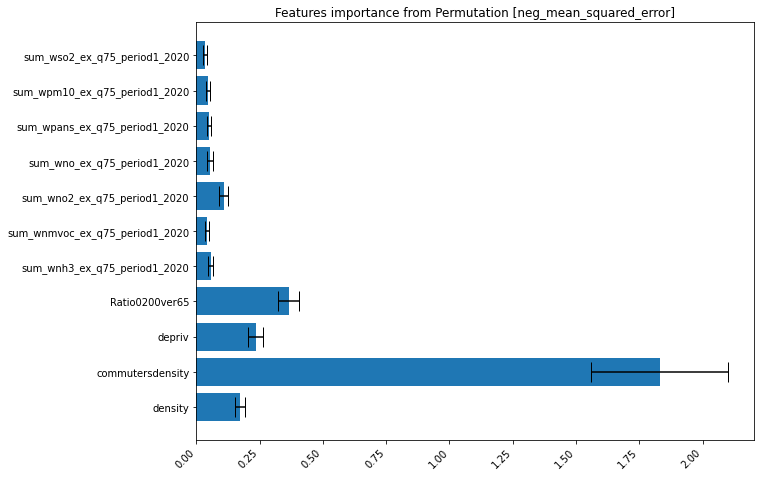

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.07884 +/- 0.00841
Feature:               commutersdensity, Score: 0.83749 +/- 0.12329
Feature:                         depriv, Score: 0.10736 +/- 0.01303
Feature:                 Ratio0200ver65, Score: 0.16668 +/- 0.01923
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.02624 +/- 0.00479
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.01880 +/- 0.00400
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.04930 +/- 0.00816
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02401 +/- 0.00548
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02279 +/- 0.00428
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.02046 +/- 0.00357
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01510 +/- 0.00345


<Figure size 432x288 with 0 Axes>

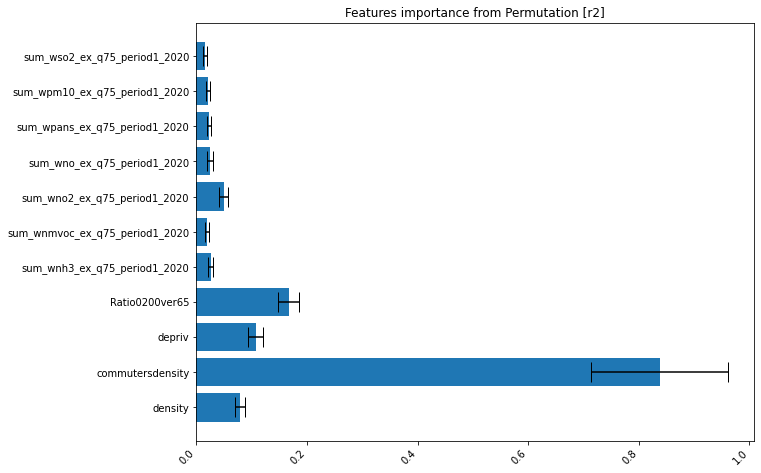

<Figure size 720x720 with 0 Axes>

((0.3744958330318788, 0.02805385776222262),
 (1.0012956116951397, 0.1123633410251261),
 0.35582533834721736,
 {'density': 0.0576715377363285,
  'commutersdensity': 0.6126276784466995,
  'depriv': 0.07853065049182702,
  'Ratio0200ver65': 0.12192456665114908,
  'sum_wnh3_ex_q75_period1_2020': 0.01919242302747138,
  'sum_wnmvoc_ex_q75_period1_2020': 0.01375353661787035,
  'sum_wno2_ex_q75_period1_2020': 0.036060297242118115,
  'sum_wno_ex_q75_period1_2020': 0.017560909367884073,
  'sum_wpans_ex_q75_period1_2020': 0.01666884682075292,
  'sum_wpm10_ex_q75_period1_2020': 0.01496291434651191,
  'sum_wso2_ex_q75_period1_2020': 0.011046639251387089},
 {'density': 0.0576715377363285,
  'commutersdensity': 0.6126276784466997,
  'depriv': 0.078530650491827,
  'Ratio0200ver65': 0.12192456665114905,
  'sum_wnh3_ex_q75_period1_2020': 0.01919242302747137,
  'sum_wnmvoc_ex_q75_period1_2020': 0.013753536617870332,
  'sum_wno2_ex_q75_period1_2020': 0.036060297242118115,
  'sum_wno_ex_q75_period1_2020': 0

<Figure size 432x288 with 0 Axes>

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_opt_using_sum", showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.39731  0.02844 
    Test set average RMSE:  1.09343  0.14597 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.39272
                       R2:  0.92942


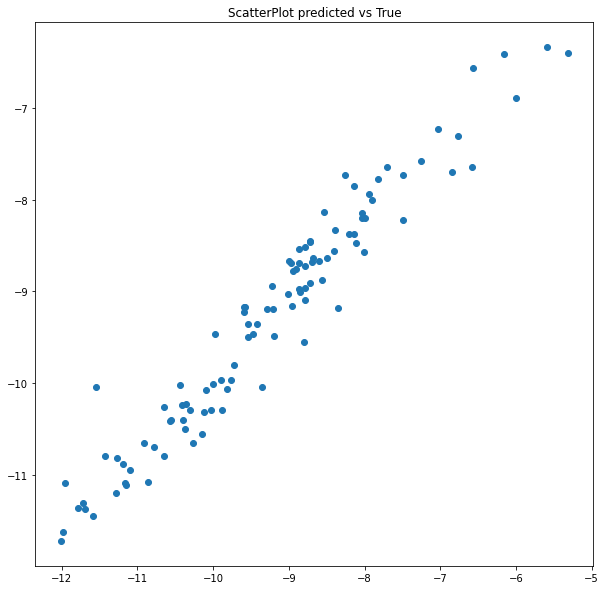

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.09519
Feature:                         depriv, Score: 0.22378
Feature:                 Ratio0200ver65, Score: 0.14649
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.15646
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.13249
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.15198
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.00933
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02780
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01976
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.03672


<Figure size 432x288 with 0 Axes>

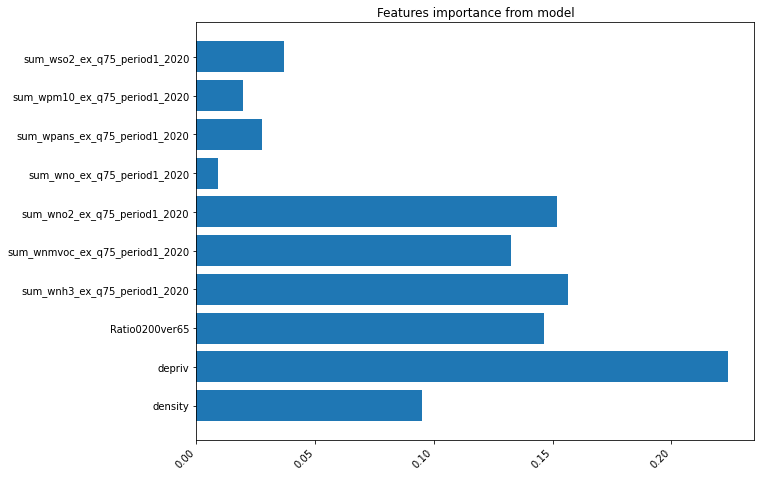

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.21564 +/- 0.02375
Feature:                         depriv, Score: 0.44637 +/- 0.04083
Feature:                 Ratio0200ver65, Score: 0.34409 +/- 0.04524
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.39291 +/- 0.05343
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.21136 +/- 0.03162
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.44330 +/- 0.05254
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.04467 +/- 0.00708
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.06205 +/- 0.00832
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.03595 +/- 0.00710
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.10751 +/- 0.02408


<Figure size 432x288 with 0 Axes>

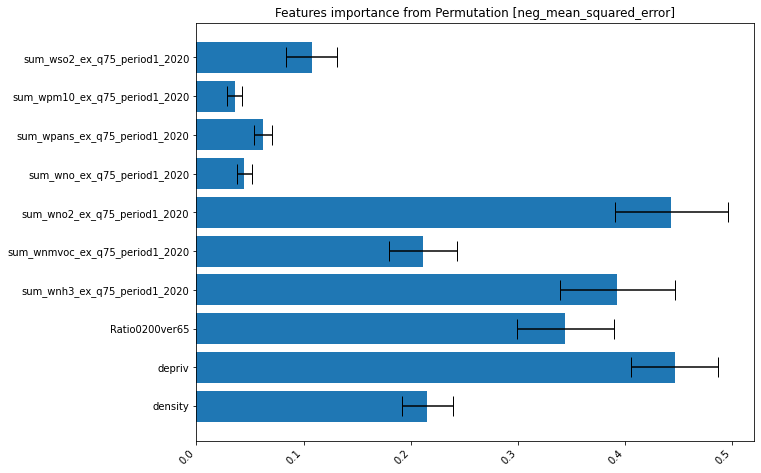

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.09868 +/- 0.01087
Feature:                         depriv, Score: 0.20426 +/- 0.01868
Feature:                 Ratio0200ver65, Score: 0.15746 +/- 0.02070
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.17980 +/- 0.02445
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.09672 +/- 0.01447
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.20286 +/- 0.02404
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02044 +/- 0.00324
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02839 +/- 0.00381
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01645 +/- 0.00325
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.04920 +/- 0.01102


<Figure size 432x288 with 0 Axes>

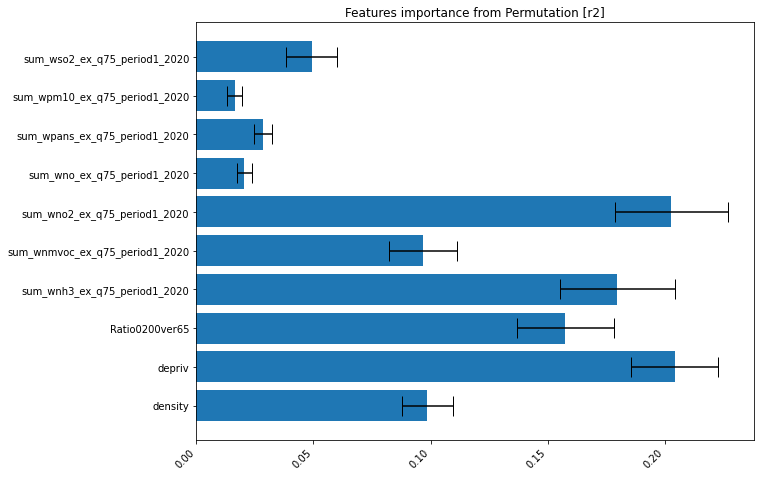

<Figure size 720x720 with 0 Axes>

((0.3973081919275757, 0.028436116138663543),
 (1.0934272777934997, 0.14597458949068123),
 0.39271858862003345,
 {'density': 0.09359770297284004,
  'depriv': 0.1937478767016824,
  'Ratio0200ver65': 0.14935545991375043,
  'sum_wnh3_ex_q75_period1_2020': 0.1705455050274352,
  'sum_wnmvoc_ex_q75_period1_2020': 0.09174340765652617,
  'sum_wno2_ex_q75_period1_2020': 0.192414825034065,
  'sum_wno_ex_q75_period1_2020': 0.019389261490732997,
  'sum_wpans_ex_q75_period1_2020': 0.02693315606432865,
  'sum_wpm10_ex_q75_period1_2020': 0.015605661957824089,
  'sum_wso2_ex_q75_period1_2020': 0.04666714318081489},
 {'density': 0.09359770297284002,
  'depriv': 0.19374787670168245,
  'Ratio0200ver65': 0.14935545991375046,
  'sum_wnh3_ex_q75_period1_2020': 0.1705455050274353,
  'sum_wnmvoc_ex_q75_period1_2020': 0.09174340765652618,
  'sum_wno2_ex_q75_period1_2020': 0.19241482503406504,
  'sum_wno_ex_q75_period1_2020': 0.01938926149073298,
  'sum_wpans_ex_q75_period1_2020': 0.026933156064328636,
  'sum_wp

<Figure size 432x288 with 0 Axes>

In [11]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_nocom_using_sum", pout=sys.stdout, showplot=True)

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.15422788984771107
2  of  1200 MSE:  0.14352862701814478
3  of  1200 MSE:  0.2791804766810065
4  of  1200 MSE:  0.3760237609973531
5  of  1200 MSE:  0.6188039766390842
6  of  1200 MSE:  0.7097621328713675
7  of  1200 MSE:  0.8417739323138791
8  of  1200 MSE:  0.89625155469655
9  of  1200 MSE:  0.2555423396272235
10  of  1200 MSE:  0.309685227150894
11  of  1200 MSE:  0.31280541280403995
12  of  1200 MSE:  0.4076378449264976
13  of  1200 MSE:  0.6188039766390842
14  of  1200 MSE:  0.7097621328713675
15  of  1200 MSE:  0.8417739323138791
16  of  1200 MSE:  0.89625155469655
17  of  1200 MSE:  0.4196060192571567
18  of  1200 MSE:  0.523014711366321
19  of  1200 MSE:  0.46233151407818585
20  of  1200 MSE:  0.5740956501683759
21  of  1200 MSE:  0.6188039766390842
22  of  1200 MSE:  0.7097621328713675
23  of  1200 MSE:  0.8417739323138791
24  of  1200 MSE:  0.89625155469655
25  of  1200 MSE:  0.5651434708647434
26  of  1200 MSE:  0.673228069062702
27  of  1200 MSE:  0.59421

Training set average RMSE:  0.37832  0.02661 
    Test set average RMSE:  1.04919  0.10483 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.35470
                       R2:  0.94243


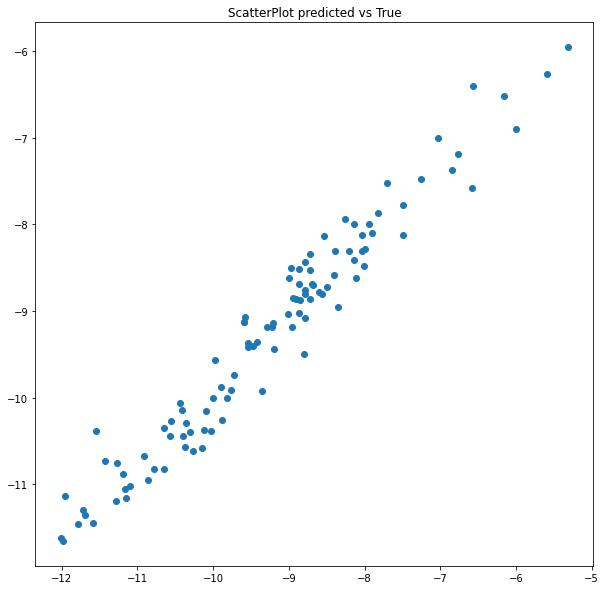

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.10051
Feature:                         depriv, Score: 0.20042
Feature:                 Ratio0200ver65, Score: 0.13375
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.11123
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.12066
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.15929
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.01843
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.03845
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.07426
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.04301


<Figure size 432x288 with 0 Axes>

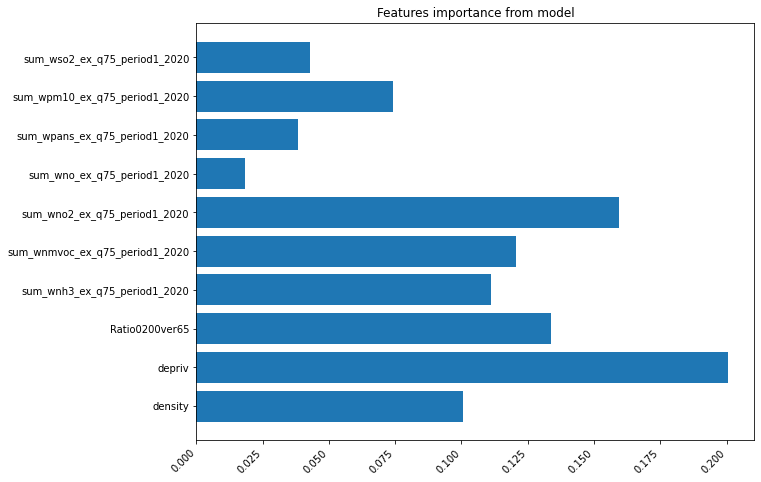

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.20628 +/- 0.02178
Feature:                         depriv, Score: 0.39412 +/- 0.03578
Feature:                 Ratio0200ver65, Score: 0.37519 +/- 0.05206
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.46181 +/- 0.06473
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.17359 +/- 0.02620
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.44996 +/- 0.05760
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.03869 +/- 0.00730
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.06180 +/- 0.01012
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.03639 +/- 0.00674
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.06645 +/- 0.01557


<Figure size 432x288 with 0 Axes>

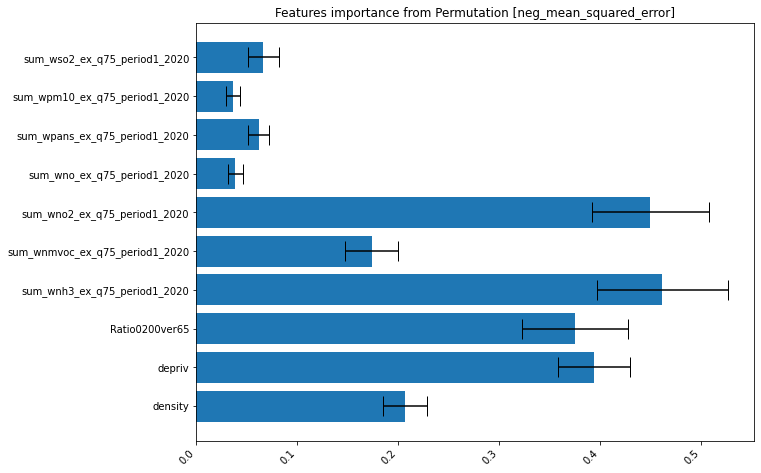

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.09440 +/- 0.00997
Feature:                         depriv, Score: 0.18035 +/- 0.01638
Feature:                 Ratio0200ver65, Score: 0.17169 +/- 0.02382
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.21133 +/- 0.02962
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.07944 +/- 0.01199
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.20591 +/- 0.02636
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.01770 +/- 0.00334
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02828 +/- 0.00463
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01665 +/- 0.00308
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.03041 +/- 0.00712


<Figure size 432x288 with 0 Axes>

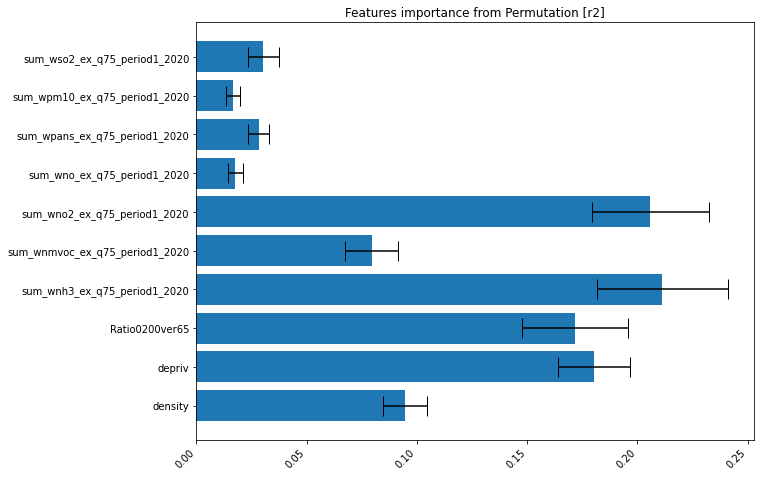

<Figure size 720x720 with 0 Axes>

((0.3783154463653557, 0.02660938609317731),
 (1.0491883276701992, 0.10482658598958003),
 0.3546968355628274,
 {'density': 0.09110161782277057,
  'depriv': 0.1740585287658743,
  'Ratio0200ver65': 0.16570213726267272,
  'sum_wnh3_ex_q75_period1_2020': 0.20395324187365793,
  'sum_wnmvoc_ex_q75_period1_2020': 0.07666367590023775,
  'sum_wno2_ex_q75_period1_2020': 0.19872110225862796,
  'sum_wno_ex_q75_period1_2020': 0.017086642632092842,
  'sum_wpans_ex_q75_period1_2020': 0.0272930695006625,
  'sum_wpm10_ex_q75_period1_2020': 0.016072627981789957,
  'sum_wso2_ex_q75_period1_2020': 0.029347356001613405},
 {'density': 0.09110161782277056,
  'depriv': 0.17405852876587438,
  'Ratio0200ver65': 0.16570213726267274,
  'sum_wnh3_ex_q75_period1_2020': 0.203953241873658,
  'sum_wnmvoc_ex_q75_period1_2020': 0.07666367590023775,
  'sum_wno2_ex_q75_period1_2020': 0.198721102258628,
  'sum_wno_ex_q75_period1_2020': 0.01708664263209282,
  'sum_wpans_ex_q75_period1_2020': 0.027293069500662494,
  'sum_wpm1

<Figure size 432x288 with 0 Axes>

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_nocom_opt_using_sum", showplot=True, optimisedparams=bestf)